In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import pickle

import ligo.skymap.plot
import healpy as hp
from ligo.skymap.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u

In [2]:
# Detection phase: sim.stats['p_det']
def p_det(lc, pcklfilename):
    plt.figure()
    plt.hist(lc.stats['p_det'])
    plt.xlabel('detection phase')
    plt.title(pcklfilename)
    plt.savefig('fig_out/p_det_'+pcklfilename[8:-4]+'.png')
    plt.show()
    
    
def redshift(lc, pcklfilename):
    plt.figure()
    plt.hist(np.concatenate([lc.meta_full['z'], lc.meta_notobserved['z']]), label='injections')
    plt.hist(lc.meta['z'], label='detections')
    plt.xlabel('redshift')
    plt.title(pcklfilename)
    plt.savefig('fig_out/redshift_'+pcklfilename[8:-4]+'.png')
    plt.show()
    
def theta(lc, pcklfilename):
    plt.figure()
    plt.hist(np.concatenate([lc.meta_full['theta'], lc.meta_notobserved['theta']]), label='injections')
    plt.hist(lc.meta['theta'], label='detections')
    plt.xlabel('viewing angle (º)')
    plt.title(pcklfilename)
    plt.savefig('fig_out/theta_'+pcklfilename[8:-4]+'.png')
    plt.show()

def det_per_night(lc, pcklfilename):
    ndet_1 = {'g':0, 'r':0, 'i':0}
    ndet_2 = {'g':0, 'r':0, 'i':0}
    ndet_3 = {'g':0, 'r':0, 'i':0}

    for i in range(len(lc.lcs)):
        time = lc.lcs[i]['time']-lc.meta['t0'][i]
        snr = lc.lcs[i]['flux']/lc.lcs[i]['fluxerr']
        if sum((lc[i]['band']=='ztfg')&(time<1)&(snr>5))>0:
            ndet_1['g'] += 1
        if sum((lc[i]['band']=='ztfg')&(1<time)&(time<2)&(snr>5))>0:
            ndet_2['g'] += 1
        if sum((lc[i]['band']=='ztfg')&(2<time)&(time<3)&(snr>5))>0:
            ndet_3['g'] += 1
        if sum((lc[i]['band']=='ztfr')&(time<1)&(snr>5))>0:
            ndet_1['r'] += 1
        if sum((lc[i]['band']=='ztfr')&(1<time)&(time<2)&(snr>5))>0:
            ndet_2['r'] += 1
        if sum((lc[i]['band']=='ztfr')&(2<time)&(time<3)&(snr>5))>0:
            ndet_3['r'] += 1
        if sum((lc[i]['band']=='ztfi')&(time<1)&(snr>5))>0:
            ndet_1['i'] += 1
        if sum((lc[i]['band']=='ztfi')&(1<time)&(time<2)&(snr>5))>0:
            ndet_2['i'] += 1
        if sum((lc[i]['band']=='ztfi')&(2<time)&(time<3)&(snr>5))>0:
            ndet_3['i'] += 1


    plt.figure()

    width=.2

    day123 = {'g': {'x': [1-width, 2-width, 3-width], 'y': [ndet_1['g'],ndet_2['g'],ndet_3['g']]},
              'r': {'x': [1, 2, 3], 'y': [ndet_1['r'],ndet_2['r'],ndet_3['r']]},
              'i': {'x': [1+width, 2+width, 3+width], 'y': [ndet_1['i'],ndet_2['i'],ndet_3['i']]}
             }

    plt.bar(day123['g']['x'],day123['g']['y'], width=width, color='green', label='g')
    plt.bar(day123['r']['x'],day123['r']['y'], width=width, color='red', label='r')
    plt.bar(day123['i']['x'],day123['i']['y'], width=width, color='orange', label='i')

    plt.legend(loc=0)
    plt.xticks([1,2,3])
    plt.ylabel('#')
    plt.xlabel('nights')
    plt.title(pcklfilename)
    plt.savefig('fig_out/detpernight_'+pcklfilename[8:-4]+'.png')
    
def plot_skymap(lcs,pcklfilename, threshold=5, pdf=None, savefig=None):
    
    plt.figure()
    ax = plt.axes(
        [0.05, 0.05, 0.9, 0.9],
        projection='geo degrees mollweide'
        #,center=center
        )
    ax.grid()
    #ax.imshow_hpx(filename)
    #levels = [c95, c90, c50]
    #cs = ax.contour_hpx(prob, levels=levels, colors='black')
    #fmt = {}
    #strs = ['95%', '90%', '50%']
    #for l, s in zip(cs.levels, strs):
    #    fmt[l] = s
    #ax.clabel(cs,fmt=fmt)
    
    ax.scatter(lcs.meta_notobserved['ra'], lcs.meta_notobserved['dec'],  transform=ax.get_transform('world'), marker='*', label='meta_notobserved', alpha=0.7)
    ax.scatter(lcs.meta_full['ra'], lcs.meta_full['dec'],  transform=ax.get_transform('world'), marker='*', label='meta_full', alpha=0.7)
    ax.scatter(lcs.meta['ra'], lcs.meta['dec'], transform=ax.get_transform('world'), marker='*', label='meta', alpha=0.7)


    #ax.legend(loc='center left', bbox_to_anchor=(0.9, .5))
    ax.legend(loc=0)
    ax.set_title(pcklfilename)

    plt.savefig('fig_out/sky_'+pcklfilename[8:-4]+'.png')
    plt.show()
    
def det_eff(lc, pcklfilename):
    ninjections = len(lc.meta_full['z'])+len(lc.meta_notobserved['z'])
    recovery_fraction = len(lc.lcs)/ ninjections*100
    
    def filter_g(lc):
        return lc[lc['band']=='ztfg']
        
    def filter_r(lc):
        return lc[lc['band']=='ztfr']
        
    def filter_i(lc):
        return lc[lc['band']=='ztfi']
    
    def filterday1(lc):
        t0 = lc.meta['t0']
        mask = np.where((t0<lc['time']) & (lc['time']<t0+1))
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        snr = flux/fluxerr
        if sum(snr>5)>0:
            return lc

    def filterday2(lc):
        t0 = lc.meta['t0']
        mask = np.where((t0+1<lc['time']) & (lc['time']<t0+2))
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        snr = flux / fluxerr
        if sum(snr > 5) > 0:
            return lc

    def filterday3(lc):
        t0 = lc.meta['t0']
        mask = np.where((t0+2<lc['time']) & (lc['time']<t0+3))
        flux = lc['flux'][mask]
        fluxerr = lc['fluxerr'][mask]
        snr = flux/fluxerr
        if sum(snr>5)>0:
            return lc

    lcs_day1 = lc.filter(filterday1)
    lcs_day2 = lc.filter(filterday2)
    lcs_day3 = lc.filter(filterday3)

    recovery_fraction_day1 = len(lcs_day1.lcs)/ninjections
    try:
        recovery_fraction_day2 = len(lcs_day2.lcs)/ninjections
    except:
        recovery_fraction_day2 = 0
    try:
        recovery_fraction_day3 = len(lcs_day3.lcs)/ninjections
    except:
        recovery_fraction_day3 = 0
        
    lcs_day1_g = lc.filter(filter_g).filter(filterday1)
    lcs_day2_g = lc.filter(filter_g).filter(filterday2)
    lcs_day3_g = lc.filter(filter_g).filter(filterday3)
    try:
        recovery_fraction_day1_g = len(lcs_day1_g.lcs)/ninjections
    except:
        recovery_fraction_day1_g = 0
    try:
        recovery_fraction_day2_g = len(lcs_day2_g.lcs)/ninjections
    except:
        recovery_fraction_day2_g = 0
    try:
        recovery_fraction_day3_g = len(lcs_day3_g.lcs)/ninjections
    except:
        recovery_fraction_day3_g = 0
        
    lcs_day1_r = lc.filter(filter_r).filter(filterday1)
    lcs_day2_r = lc.filter(filter_r).filter(filterday2)
    lcs_day3_r = lc.filter(filter_r).filter(filterday3)
    try:
        recovery_fraction_day1_r = len(lcs_day1_r.lcs)/ninjections
    except:
        recovery_fraction_day1_r = 0
    try:
        recovery_fraction_day2_r = len(lcs_day2_r.lcs)/ninjections
    except:
        recovery_fraction_day2_r = 0
    try:
        recovery_fraction_day3_r = len(lcs_day3_r.lcs)/ninjections
    except:
        recovery_fraction_day3_r = 0

        
    lcs_day1_i = lc.filter(filter_i).filter(filterday1)
    lcs_day2_i = lc.filter(filter_i).filter(filterday2)
    lcs_day3_i = lc.filter(filter_i).filter(filterday3)
    try:
        recovery_fraction_day1_i = len(lcs_day1_i.lcs)/ninjections
    except:
        recovery_fraction_day1_i = 0
    try:
        recovery_fraction_day2_i = len(lcs_day2_i.lcs)/ninjections
    except:
        recovery_fraction_day2_i = 0
    try:
        recovery_fraction_day3_i = len(lcs_day3_i.lcs)/ninjections
    except:
        recovery_fraction_day3_i = 0
    
    plt.figure()    
    
    x = 2
    y = np.round(recovery_fraction, decimals=1)
    wd = 3
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    x = 1
    y = np.round(recovery_fraction_day1*100, decimals=1)
    wd = .95
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    wd = .25
    y = np.round(recovery_fraction_day1_g*100, decimals=1)
    plt.bar(x-wd-.05,   y,  wd, color='green', alpha=.2, label='g')
    plt.text(x-wd-.05,  y-.1, str(y)+'%', color='green', va='top', ha='center')
    y = np.round(recovery_fraction_day1_r*100, decimals=1)
    plt.bar(x,   y,  wd, color='red', alpha=.2, label='r')
    plt.text(x,  y-.1, str(y)+'%', color='red', va='top', ha='center')
    y = np.round(recovery_fraction_day1_i*100, decimals=1)
    plt.bar(x+wd+.05,   y,  wd, color='brown', alpha=.2, label='i')
    plt.text(x+wd+.05,  y-.1, str(y)+'%', color='brown', va='top', ha='center')
    
    
    
    x = 2
    y = np.round(recovery_fraction_day2*100, decimals=1)
    wd = .95
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    wd = .25
    y = np.round(recovery_fraction_day2_g*100, decimals=1)
    plt.bar(x-wd-.05,   y,  wd, color='green', alpha=.2)
    plt.text(x-wd-.05,  y-.1, str(y)+'%', color='green', va='top', ha='center')
    y = np.round(recovery_fraction_day2_r*100, decimals=1)
    plt.bar(x,   y,  wd, color='red', alpha=.2)
    plt.text(x,  y-.1, str(y)+'%', color='red', va='top', ha='center')
    y = np.round(recovery_fraction_day2_i*100, decimals=1)
    plt.bar(x+wd+.05,   y,  wd, color='brown', alpha=.2)
    plt.text(x+wd+.05,  y-.1, str(y)+'%', color='brown', va='top', ha='center')
    
    
    
    x = 3
    y = np.round(recovery_fraction_day3*100, decimals=1)
    wd = .95
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    wd = .25
    y = np.round(recovery_fraction_day3_g*100, decimals=1)
    plt.bar(x-wd-.05,   y,  wd, color='green', alpha=.2)
    plt.text(x-wd-.05,  y-.1, str(y)+'%', color='green', va='top', ha='center')
    y = np.round(recovery_fraction_day3_r*100, decimals=1)
    plt.bar(x,   y,  wd, color='red', alpha=.2)
    plt.text(x,  y-.1, str(y)+'%', color='red', va='top', ha='center')
    y = np.round(recovery_fraction_day3_i*100, decimals=1)
    plt.bar(x+wd+.05,   y,  wd, color='brown', alpha=.2)
    plt.text(x+wd+.05,  y-.1, str(y)+'%', color='brown', va='top', ha='center')
    
    plt.ylim(0,recovery_fraction+5)
    plt.xticks([1,2,3])
    plt.ylabel('% recovery fraction')
    plt.xlabel('nights')
    plt.legend(loc=0)
    plt.title(pcklfilename)
    plt.savefig('fig_out/deteff_'+pcklfilename[8:-4]+'.png')
    plt.show()
    
def eff_faderate(lc, pcklfilename):
    # filter fade rate
    def filterfaderate(lc):
        pass_ = True
        #min_dt = .125 # 3 hrs
        min_dt = .02 # 30 minutes
        min_fade = .3
        f3s = lc['flux']/lc['fluxerr']>=3
        t3s = lc['time'][f3s]
        f5s = lc['flux']/lc['fluxerr']>=5
        t5s = lc['time'][f5s]
        if sum(f5s)==1 and t5s[0]==t3s[0]:
            pass_ = False
        filters = lc['band'][f3s]
        evol_rate = []
        for f in set(filters):
            times_f_ = lc['time'][f3s][np.where(filters == f)[0]]
            mags_f_ = 30 - 2.5 * np.log10(lc['flux'][f3s][np.where(filters == f)[0]])
            peakmag_f = np.min(mags_f_)
            timepeak_f = times_f_[mags_f_==peakmag_f]
            times_f = times_f_[times_f_>=timepeak_f]
            mags_f = mags_f_[times_f_>=timepeak_f]
            dt_f = np.max(times_f) - np.min(times_f)
            if dt_f > min_dt:
                evol_rate_f = (np.max(mags_f) - np.min(mags_f)) / (times_f[np.where(mags_f == np.max(mags_f))[0]][0] - times_f[np.where(mags_f == np.min(mags_f))[0]][0])
                evol_rate.append(evol_rate_f)
            else:
                evol_rate.append(0)
        if np.max(evol_rate) > min_fade and pass_:
            return lc
    
        
    ninjections = len(lc.meta_full['z'])+len(lc.meta_notobserved['z'])
    lc_faderate = lc.filter(filterfaderate)
    recovery_fraction = len(lc_faderate.lcs)/ ninjections*100
    
    def filter_g(lc):
        return lc[lc['band']=='ztfg']
        
    def filter_r(lc):
        return lc[lc['band']=='ztfr']
        
    def filter_i(lc):
        return lc[lc['band']=='ztfi']
    
    def filterday1(lc):
        t0 = lc.meta['t0']
        mask = np.where((t0<lc['time']) & (lc['time']<t0+1))
        return lc[mask]

    def filterday2(lc):
        t0 = lc.meta['t0']
        mask = np.where((t0<lc['time']) & (lc['time']<t0+2))
        return lc[mask]

    def filterday3(lc):
        t0 = lc.meta['t0']
        mask = np.where((t0<lc['time']) & (lc['time']<t0+3))
        return lc[mask]
    
    lcs_day1 = lc.filter(filterday1).filter(filterfaderate)
    lcs_day2 = lc.filter(filterday2).filter(filterfaderate)
    lcs_day3 = lc.filter(filterday3).filter(filterfaderate)

    recovery_fraction_day1 = len(lcs_day1.lcs)/ninjections
    try:
        recovery_fraction_day2 = len(lcs_day2.lcs)/ninjections
    except:
        recovery_fraction_day2 = 0
    try:
        recovery_fraction_day3 = len(lcs_day3.lcs)/ninjections
    except:
        recovery_fraction_day3 = 0
        
    lcs_day1_g = lc.filter(filter_g).filter(filterday1).filter(filterfaderate)
    lcs_day2_g = lc.filter(filter_g).filter(filterday2).filter(filterfaderate)
    lcs_day3_g = lc.filter(filter_g).filter(filterday3).filter(filterfaderate)
    try:
        recovery_fraction_day1_g = len(lcs_day1_g.lcs)/ninjections
    except:
        recovery_fraction_day1_g = 0
    try:
        recovery_fraction_day2_g = len(lcs_day2_g.lcs)/ninjections
    except:
        recovery_fraction_day2_g = 0
    try:
        recovery_fraction_day3_g = len(lcs_day3_g.lcs)/ninjections
    except:
        recovery_fraction_day3_g = 0
        
    lcs_day1_r = lc.filter(filter_r).filter(filterday1).filter(filterfaderate)
    lcs_day2_r = lc.filter(filter_r).filter(filterday2).filter(filterfaderate)
    lcs_day3_r = lc.filter(filter_r).filter(filterday3).filter(filterfaderate)
    try:
        recovery_fraction_day1_r = len(lcs_day1_r.lcs)/ninjections
    except:
        recovery_fraction_day1_r = 0
    try:
        recovery_fraction_day2_r = len(lcs_day2_r.lcs)/ninjections
    except:
        recovery_fraction_day2_r = 0
    try:
        recovery_fraction_day3_r = len(lcs_day3_r.lcs)/ninjections
    except:
        recovery_fraction_day3_r = 0

        
    try: 
        lcs_day1_i = lc.filter(filter_i).filter(filterday1).filter(filterfaderate)
    except:
        lcs_day1_i = 0
    lcs_day2_i = lc.filter(filter_i).filter(filterday2).filter(filterfaderate)
    lcs_day3_i = lc.filter(filter_i).filter(filterday3).filter(filterfaderate)
    try:
        recovery_fraction_day1_i = len(lcs_day1_i.lcs)/ninjections
    except:
        recovery_fraction_day1_i = 0
    try:
        recovery_fraction_day2_i = len(lcs_day2_i.lcs)/ninjections
    except:
        recovery_fraction_day2_i = 0
    try:
        recovery_fraction_day3_i = len(lcs_day3_i.lcs)/ninjections
    except:
        recovery_fraction_day3_i = 0
    
    plt.figure()    
    
    x = 2
    y = np.round(recovery_fraction, decimals=1)
    wd = 3
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')

    
    x = 1
    y = np.round(recovery_fraction_day1*100, decimals=1)
    wd = .95
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    wd = .25
    y = np.round(recovery_fraction_day1_g*100, decimals=1)
    plt.bar(x-wd-.05,   y,  wd, color='green', alpha=.2, label='g')
    plt.text(x-wd-.05,  y-.1, str(y)+'%', color='green', va='top', ha='center')
    y = np.round(recovery_fraction_day1_r*100, decimals=1)
    plt.bar(x,   y,  wd, color='red', alpha=.2, label='r')
    plt.text(x,  y-.1, str(y)+'%', color='red', va='top', ha='center')
    y = np.round(recovery_fraction_day1_i*100, decimals=1)
    plt.bar(x+wd+.05,   y,  wd, color='brown', alpha=.2, label='i')
    plt.text(x+wd+.05,  y-.1, str(y)+'%', color='brown', va='top', ha='center')
    
    
    
    x = 2
    y = np.round(recovery_fraction_day2*100, decimals=1)
    wd = .95
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    wd = .25
    y = np.round(recovery_fraction_day2_g*100, decimals=1)
    plt.bar(x-wd-.05,   y,  wd, color='green', alpha=.2)
    plt.text(x-wd-.05,  y-.1, str(y)+'%', color='green', va='top', ha='center')
    y = np.round(recovery_fraction_day2_r*100, decimals=1)
    plt.bar(x,   y,  wd, color='red', alpha=.2)
    plt.text(x,  y-.1, str(y)+'%', color='red', va='top', ha='center')
    y = np.round(recovery_fraction_day2_i*100, decimals=1)
    plt.bar(x+wd+.05,   y,  wd, color='brown', alpha=.2)
    plt.text(x+wd+.05,  y-.1, str(y)+'%', color='brown', va='top', ha='center')
    
    
    
    x = 3
    y = np.round(recovery_fraction_day3*100, decimals=1)
    wd = .95
    plt.bar(x,y,wd, color='grey', alpha=.2)
    plt.text(x, y+.1, str(y)+'%', color='grey')
    
    wd = .25
    y = np.round(recovery_fraction_day3_g*100, decimals=1)
    plt.bar(x-wd-.05,   y,  wd, color='green', alpha=.2)
    plt.text(x-wd-.05,  y-.1, str(y)+'%', color='green', va='top', ha='center')
    y = np.round(recovery_fraction_day3_r*100, decimals=1)
    plt.bar(x,   y,  wd, color='red', alpha=.2)
    plt.text(x,  y-.1, str(y)+'%', color='red', va='top', ha='center')
    y = np.round(recovery_fraction_day3_i*100, decimals=1)
    plt.bar(x+wd+.05,   y,  wd, color='brown', alpha=.2)
    plt.text(x+wd+.05,  y-.1, str(y)+'%', color='brown', va='top', ha='center')
    
    
    
    
    #plt.ylim(0,recovery_fraction+5)
    plt.xticks([1,2,3])
    plt.ylabel('% passing faderate criteria')
    plt.xlabel('nights')
    plt.legend(loc=0)
    plt.title(pcklfilename)
    plt.savefig('fig_out/faderateeff_'+pcklfilename[8:-4]+'.png')
    plt.show()
    
def eff_theta_red(lc, pcklfilename):
    ninjections = len(lc.meta_full['z'])+len(lc.meta_notobserved['z'])
    zbins = np.linspace(lc.meta['z'].min(),lc.meta['z'].max(),10)
    thetabins = np.linspace(lc.meta['theta'].min(),lc.meta['theta'].max(),10)
    plt.figure()
    h, x,y = np.histogram2d(lc.meta['z'], lc.meta['theta'],bins=[zbins,thetabins])
    hall,xall, yall = np.histogram2d(np.concatenate([lc.meta_full['z'], lc.meta_notobserved['z']]), 
                               np.concatenate([lc.meta_full['theta'], lc.meta_notobserved['theta']]),
                              bins=[zbins,thetabins])
    im = plt.imshow(h/hall, aspect='auto', origin='lower', extent=(x.min(), x.max(), y.min(), y.max()))
    plt.colorbar(im)
    
    plt.title(pcklfilename)
    plt.savefig('fig_out/effthetared_'+pcklfilename[8:-4]+'.png')
    plt.show()
    
    

In [280]:
!open .

lcs_out/lcs_1045_240_grg_gri_rir.pkl
2142


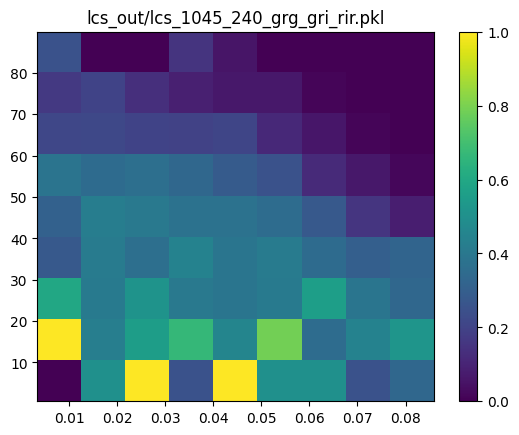

lcs_out/lcs_1045_240_grg_grg_grg.pkl
3125


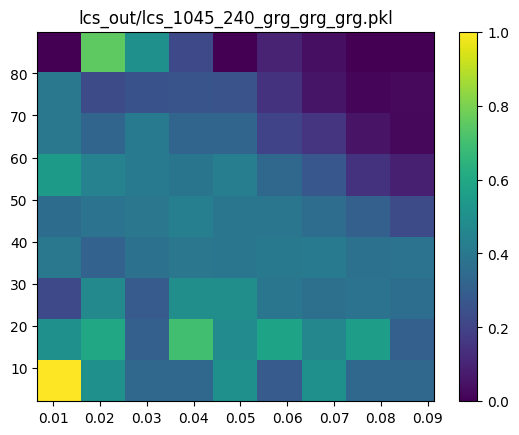

lcs_out/lcs_1045_240_rgr_rir_rir.pkl
3758


/Users/anasaguescarracedo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:493: RuntimeWarning: invalid value encountered in true_divide


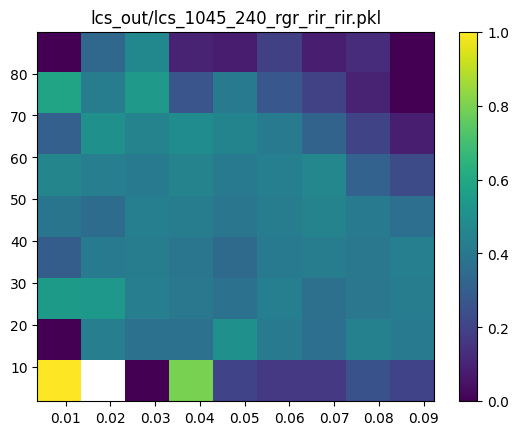

lcs_out/lcs_1045_300_grg_gri_rir.pkl
2913


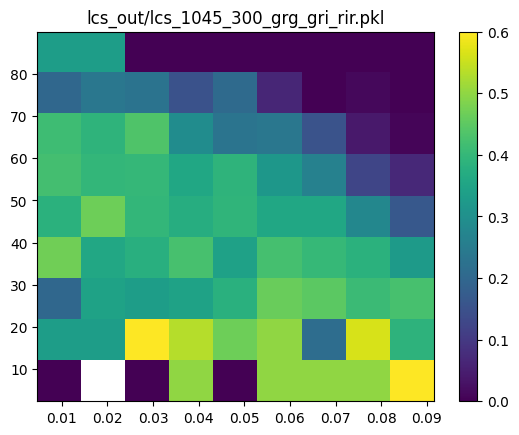

lcs_out/lcs_1045_300_grg_grg_grg.pkl
3524


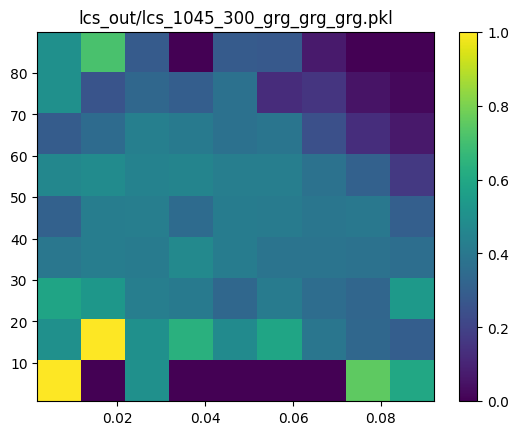

lcs_out/lcs_1045_300_rgr_rir_rir.pkl
384


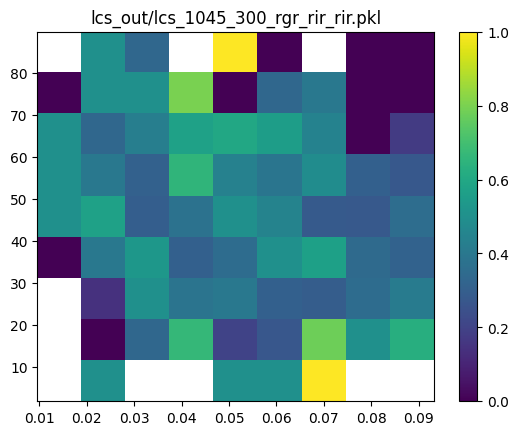

In [281]:
localizations =['1045', '1045']#,'1324', '1324','1458','1458']
exptimes =     ['240' , '300' ]#,'240' , '300' ,'240' , '300']
ztfstrategys = ['grg_gri_rir' , 'grg_grg_grg', 'rgr_rir_rir']

for i in range(len(localizations)):
    localization = localizations[i]
    exptime = exptimes[i]

    for ztfstrategy in ztfstrategys:
        pcklfilename = 'lcs_out/lcs_'+localization+'_'+exptime+'_'+ztfstrategy+'.pkl'
        print(pcklfilename)
        lcs = pickle.load(open(pcklfilename, 'rb'))
        print(len(lcs.lcs))
        #p_det(lcs, pcklfilename)
        #det_eff(lcs, pcklfilename)
        #eff_faderate(lcs, pcklfilename)
        #redshift(lcs, pcklfilename)
        #theta(lcs, pcklfilename)
        #det_per_night(lcs,pcklfilename)
        #plot_in_s(lcs, pcklfilename)
        #plot_skymap(lcs, pcklfilename)
        #plot(lcs, 1, pdf=pdf)
        eff_theta_red(lcs, pcklfilename)


        '''plot_skymap(lcs, 2, pdf=pdf)
        #plot(lcs, 2, pdf=pdf)

        pdf.close()'''

In [ ]:
import glob

l = glob.glob('too_strategies/*_limmag.csv')
for i in l: 
    df = pd.read_csv(i)
    plt.figure(figsize=(5,3))
    plt.scatter(df.time, df.filt)
    plt.title(i)
    plt.show()

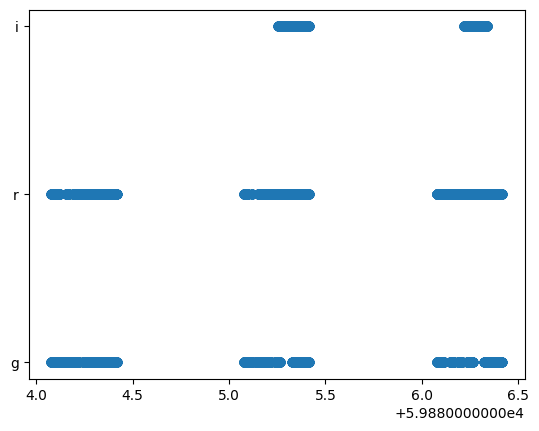

In [3]:
df = pd.read_csv('too_strategies/1045_300_grg_gri_rir_limmag.csv')
plt.figure()
plt.scatter(df.time, df.filt)

In [4]:

df

,fieldid,ra,dec,time,limmag,exptime,prob,airmass,filt,success,ccdid
0,855,36.00000,76.55,59884.07819,22.900036,299,0.04633,1.81218,g,-1,1
1,855,36.00000,76.55,59884.07819,22.582240,299,0.04633,1.81218,g,-1,2
2,855,36.00000,76.55,59884.07819,20.795941,299,0.04633,1.81218,g,-1,3
3,855,36.00000,76.55,59884.07819,21.647944,299,0.04633,1.81218,g,-1,4
4,855,36.00000,76.55,59884.07819,21.184955,299,0.04633,1.81218,g,-1,5
...,...,...,...,...,...,...,...,...,...,...,...
19291,503,29.71062,11.75,59886.29730,21.897014,299,0.00745,1.07577,r,-1,12
19292,503,29.71062,11.75,59886.29730,20.665927,299,0.00745,1.07577,r,-1,13
19293,503,29.71062,11.75,59886.29730,22.281869,299,0.00745,1.07577,r,-1,14
19294,503,29.71062,11.75,59886.29730,19.496689,299,0.00745,1.07577,r,-1,15


In [18]:

df.groupby(['time'], as_index=False).mean()

,time,fieldid,ra,dec,limmag,exptime,prob,airmass,success,ccdid
0,59884.07819,855.0,36.00000,76.55,21.224472,275.4,0.04633,1.81218,-1.0,8.5
1,59884.08109,854.0,12.00000,76.55,21.253014,240.0,0.03372,1.58220,-1.0,8.5
2,59884.08178,854.0,12.00000,76.55,21.157655,299.0,0.03372,1.58038,-1.0,8.5
3,59884.08398,868.0,348.00000,76.55,21.103911,240.0,0.01232,1.44150,-1.0,8.5
4,59884.08537,868.0,348.00000,76.55,21.077841,299.0,0.01232,1.43953,-1.0,8.5
...,...,...,...,...,...,...,...,...,...,...
577,59886.40135,660.0,94.08393,33.35,21.172925,299.0,0.00708,1.06537,-1.0,8.5
578,59886.40494,1843.0,68.79756,65.75,21.165990,299.0,0.00666,1.18524,-1.0,8.5
579,59886.40853,1865.0,52.43831,72.95,20.994037,299.0,0.00519,1.32390,-1.0,8.5
580,59886.41212,1744.0,90.53215,44.15,21.177335,299.0,0.00323,1.04526,-1.0,8.5


In [284]:
df.time.min(), df.time.max()

(59884.07819, 59886.41571)

/Users/anasaguescarracedo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


KeyboardInterrupt: 

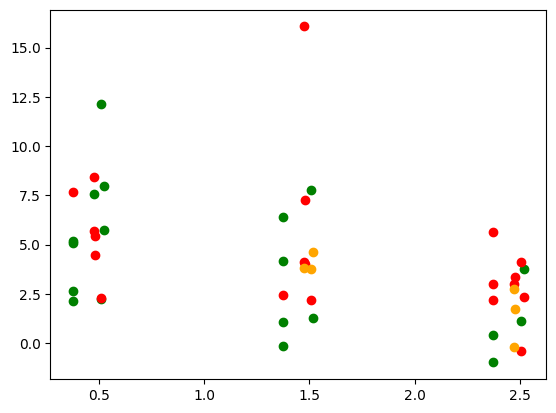

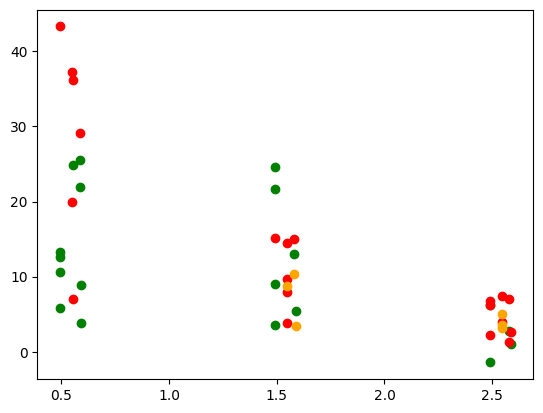

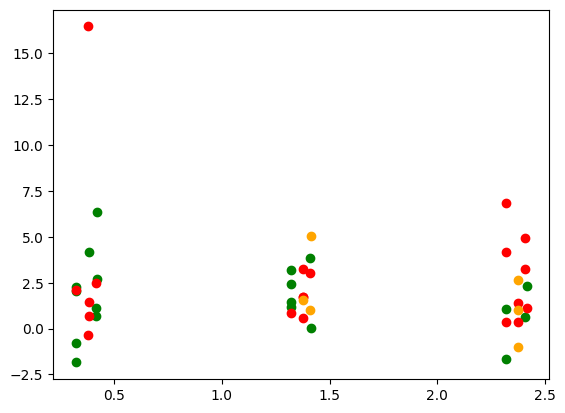

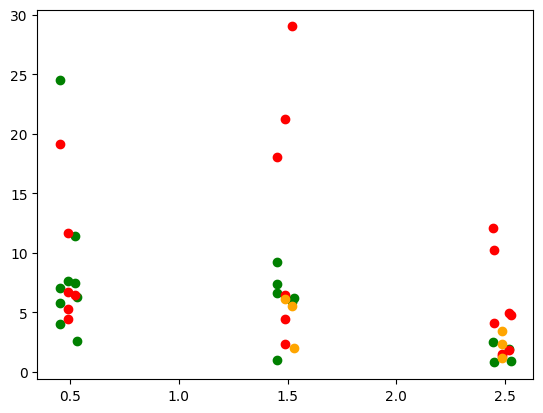

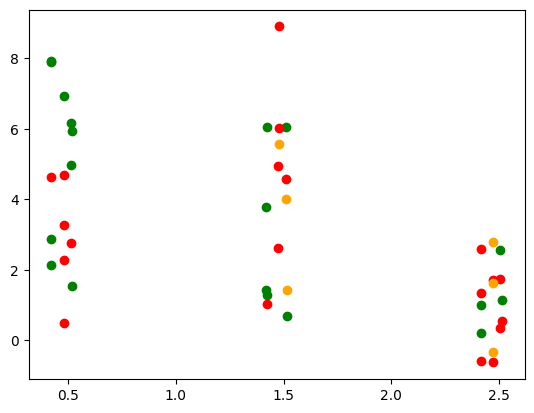

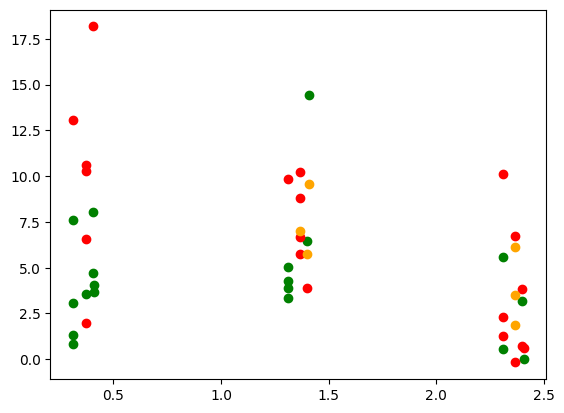

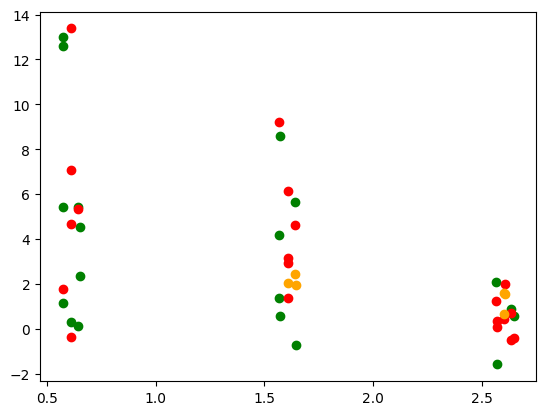

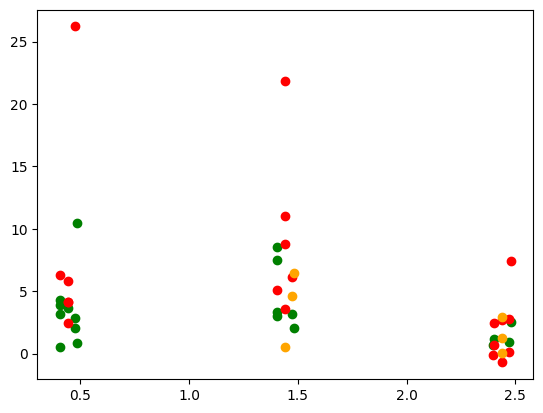

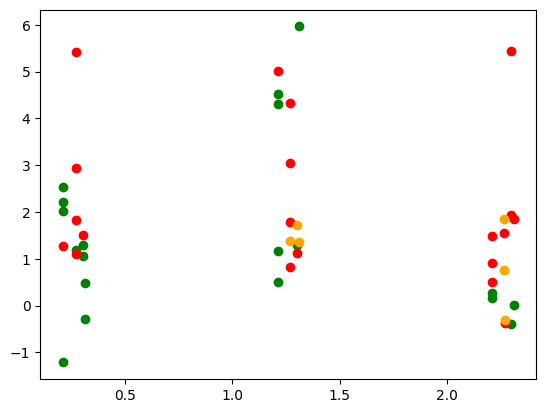

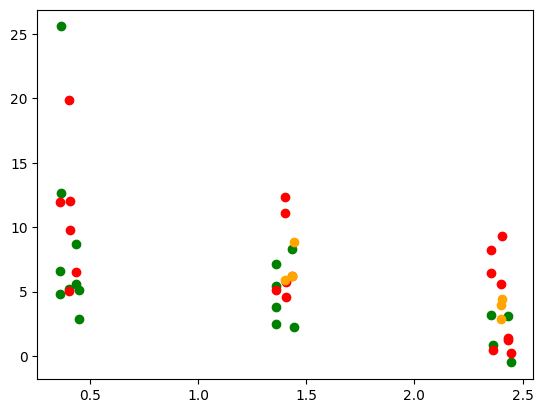

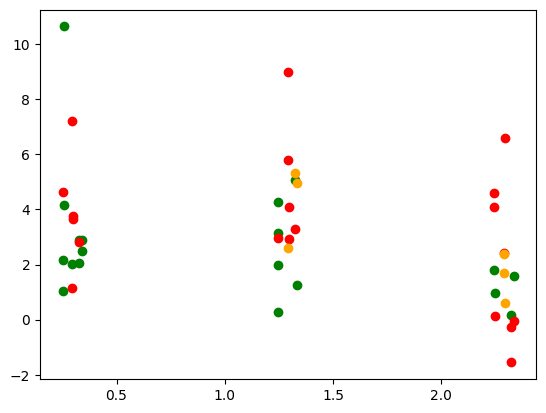

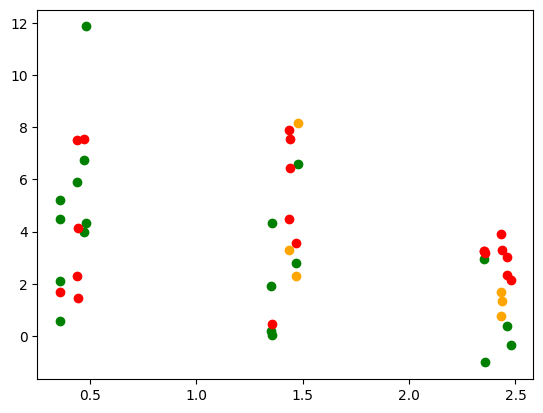

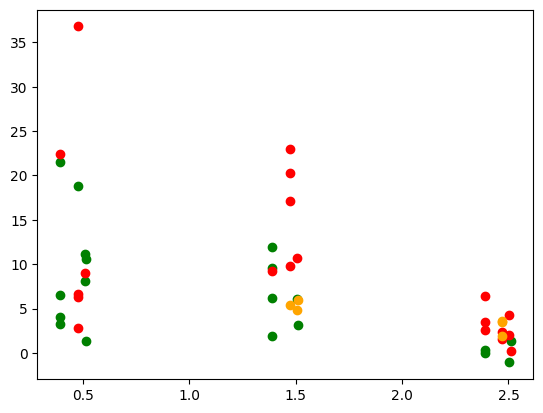

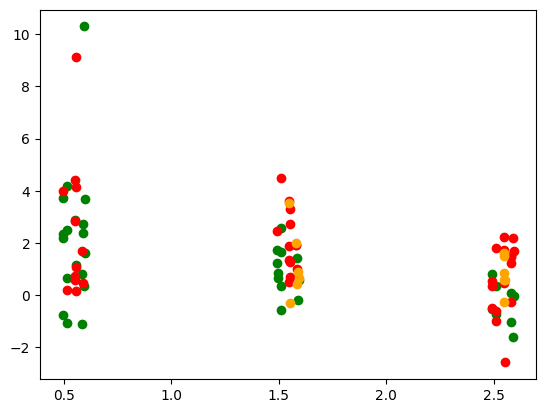

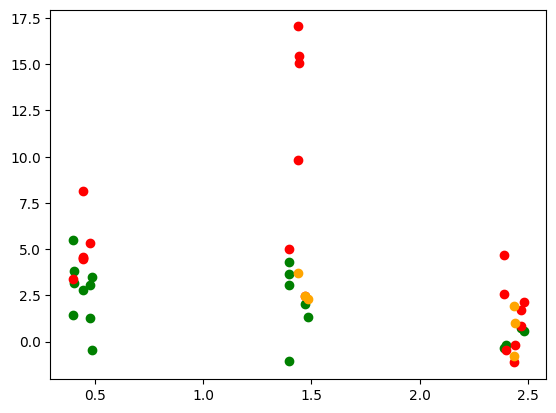

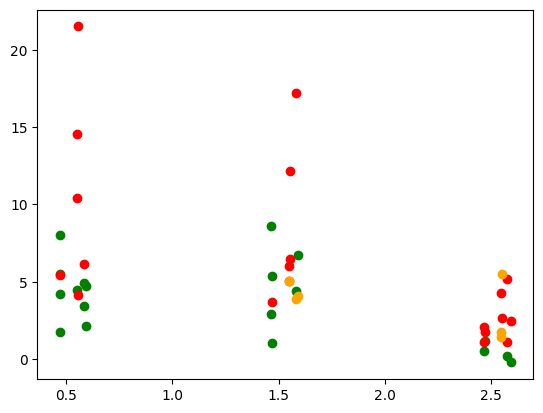

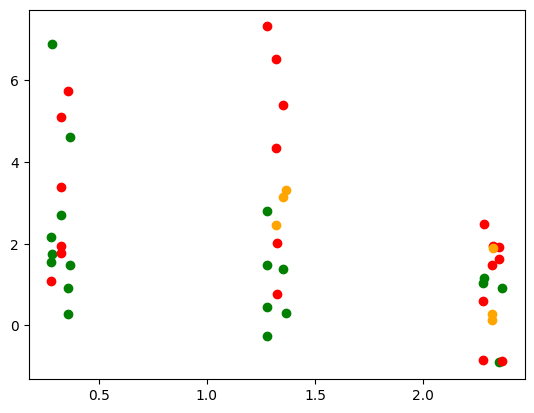

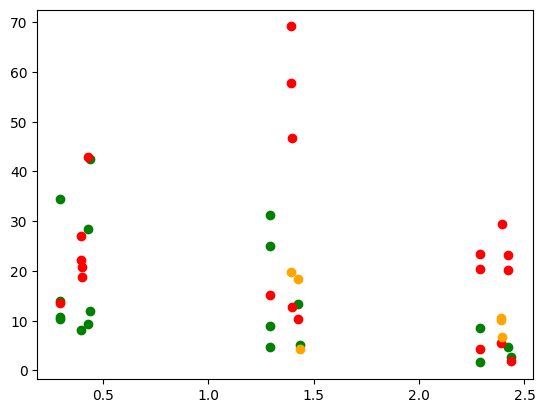

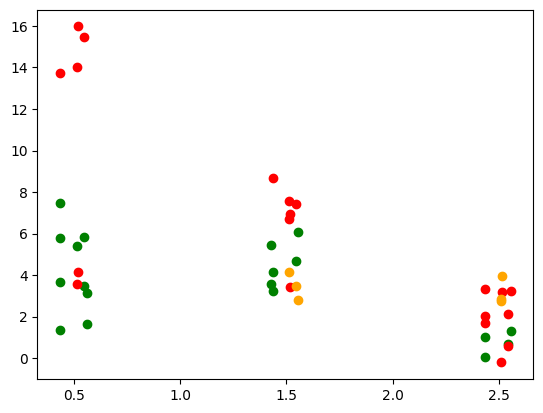

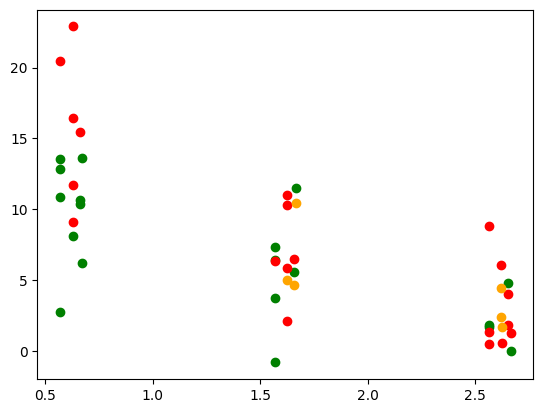

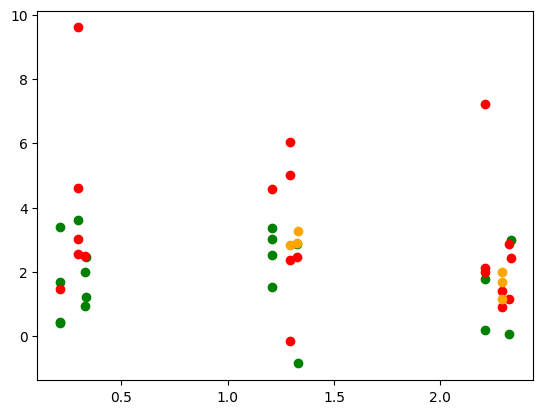

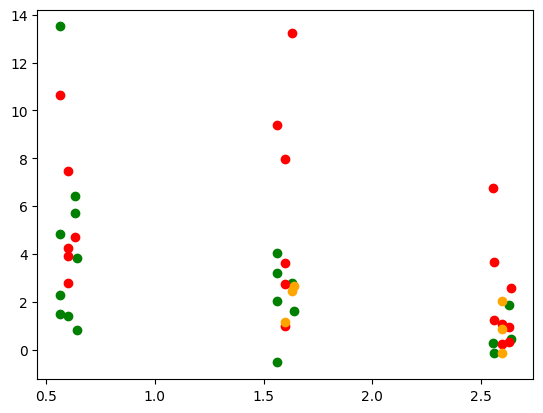

Error in callback <function flush_figures at 0x7fe556060680> (for post_execute):


KeyboardInterrupt: 

In [228]:
lcs = pickle.load(open('lcs_out/lcs_1045_240_rgr_rir_rir.pkl', 'rb'))
for i in range(len(lcs.lcs)):
    lc = lcs[i]
    t0 = lc.meta['t0']
    plt.figure()
    mask = lc['band']=='ztfg'
    plt.scatter(lc['time'][mask]-t0, lc['flux'][mask]/lc['fluxerr'][mask], c='green')
    mask = lc['band']=='ztfr'
    plt.scatter(lc['time'][mask]-t0, lc['flux'][mask]/lc['fluxerr'][mask], c='red')
    mask = lc['band']=='ztfi'
    plt.scatter(lc['time'][mask]-t0, lc['flux'][mask]/lc['fluxerr'][mask], c='orange')